In [115]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [116]:
# Load the data
data = pd.read_csv('channels.csv')

In [117]:
# Remove "data/" prefix from column names if it exists
data.columns = data.columns.str.replace('data/', '')
data.head()

,channel_tier_name,channel_tier,channel_tier_last,channel,channel_age,influential_casters/0,influential_casters/1,influential_casters/2,top_domains/0,top_domains/1,...,top_casters/6,top_casters/7,top_casters/8,top_casters/9,got_replies,wow_reply,got_likes,wow_likes,got_recasts,wow_recasts
0,stadium,4,4,masks,104,mistershot,meguce,angelikakollin,i.pinimg.com,code.lqotp.site,...,amir7867,mikaella,sadeq-sa,segnik,790429,-622771,858304.0,-401843.0,59548.0,-80249.0
1,stadium,4,4,superrare,286,ted,wellzy,mantine.eth,superrare.com,build.top,...,srfwswsrfwswstfj,song1004.eth,iim,5926559592655991,339485,-38447,627519.0,-20578.0,59032.0,4255.0
2,stadium,4,4,degen,335,purp,satoushi,samantha,build.top,wallet.coinbase.com,...,sarfraztanoli,alreadythere,zozypapa76,danelya,79972,932,105083.0,-6438.0,11580.0,1483.0
3,stadium,4,4,lp,183,mantine.eth,satoushi,wellzy,build.top,far.quest,...,punk2th,tomcruise0,dopplebin.eth,yongchi,161223,-35732,121333.0,-38920.0,19638.0,-6226.0
4,stadium,4,4,airstack,228,mantine.eth,meguce,mistershot,moxie-frames.airstack.xyz,build.top,...,mejakayu,7092285709228532,rondar,hong2004,81843,69876,141859.0,108391.0,25677.0,18588.0


In [118]:
# Combine `influential_casters/0`, `influential_casters/1`, `influential_casters/2` into a single `Influencers` column
data['Influencers'] = data[['influential_casters/0', 'influential_casters/1', 'influential_casters/2']].apply(lambda x: ','.join(x.dropna().astype(str)), axis=1)

# Combine top_domains columns into a single column
top_domains_cols = [col for col in data.columns if 'top_domains' in col]
data['Top_Domains'] = data[top_domains_cols].apply(lambda x: ','.join(x.dropna().astype(str)), axis=1)

# Drop columns that contain "influential_casters/" in their name
data = data.loc[:, ~data.columns.str.contains('influential_casters/', case=False)]

# Drop columns that contain "top_domains/" in their name
data = data.loc[:, ~data.columns.str.contains('top_domains/', case=False)]

data.head()

,channel_tier_name,channel_tier,channel_tier_last,channel,channel_age,engagement,wow_engage,got_casts,wow_cast,casters,...,top_casters/8,top_casters/9,got_replies,wow_reply,got_likes,wow_likes,got_recasts,wow_recasts,Influencers,Top_Domains
0,stadium,4,4,masks,104,639526.263243,-461133.016250,42127,-31518,16181.0,...,sadeq-sa,segnik,790429,-622771,858304.0,-401843.0,59548.0,-80249.0,"mistershot,meguce,angelikakollin","i.pinimg.com,code.lqotp.site,client.warpcast.com"
1,stadium,4,4,superrare,286,256197.314864,250.303224,26204,-1069,7077.0,...,iim,5926559592655991,339485,-38447,627519.0,-20578.0,59032.0,4255.0,"ted,wellzy,mantine.eth","superrare.com,build.top,foundation.app"
2,stadium,4,4,degen,335,132567.455358,-8382.825650,10891,-68,8829.0,...,zozypapa76,danelya,79972,932,105083.0,-6438.0,11580.0,1483.0,"purp,satoushi,samantha","build.top,wallet.coinbase.com,lunchbreak.com"
3,stadium,4,4,lp,183,129580.163758,-28578.499422,9227,-1685,5225.0,...,dopplebin.eth,yongchi,161223,-35732,121333.0,-38920.0,19638.0,-6226.0,"mantine.eth,satoushi,wellzy","build.top,far.quest,zora.co"
4,stadium,4,4,airstack,228,127043.960276,92532.446287,14142,11270,9882.0,...,rondar,hong2004,81843,69876,141859.0,108391.0,25677.0,18588.0,"mantine.eth,meguce,mistershot","moxie-frames.airstack.xyz,build.top,airstack.xyz"


### <font color='Blue'> Unique Identifiers and domains </font>

In [119]:
# Create a set of unique influencers and domains
unique_influencers = set(data['Influencers'].str.split(',').explode())
unique_domains = set(data['Top_Domains'].str.split(',').explode())

# number of unique elements
num_unique_influencers = len(unique_influencers)
num_unique_domains = len(unique_domains)

print(f"Number of Unique Influencers: {num_unique_influencers}")
print(f"Number of Unique Top Domains: {num_unique_domains}")

Number of Unique Influencers: 199
Number of Unique Top Domains: 960


### <font color='Blue'> Influencers per channels </font>

In [120]:
# Influencers Sticking to a Particular Channel

def get_influencer_channel_distribution(influencer, data):
  influencer_data = data[data['Influencers'].str.contains(influencer)]
  channel_counts = influencer_data['channel_tier_name'].value_counts(normalize=True)
  return channel_counts

def get_influencers_by_channel_dominance(data, dominance_threshold=0.8):
  influencers = set(data['Influencers'].str.split(',').explode())
  dominant_influencers = {}
  for influencer in influencers:
    channel_distribution = get_influencer_channel_distribution(influencer, data)
    if channel_distribution.max() >= dominance_threshold:
      dominant_channel = channel_distribution.idxmax()
      dominant_influencers[influencer] = dominant_channel
  return dominant_influencers


# Example usage:
dominant_influencers = get_influencers_by_channel_dominance(data, dominance_threshold=0.8)

# DataFrame for better readability
dominant_influencer_df = pd.DataFrame({'influencer': list(dominant_influencers.keys()), 'dominant_channel': list(dominant_influencers.values())})
# dominant_influencer_df.head()

# Grouping by dominant channel and count influencers
channel_influencer_counts = dominant_influencer_df.groupby('dominant_channel').size().reset_index(name='influencer_count')

print(channel_influencer_counts)

  dominant_channel  influencer_count
0          friends                26
1            niche                 1
2            quiet                10


#### Inferences: 

1. A significant portion of influencers (26) primarily focus on the "friends" channel, suggesting a strong community-driven approach. 
2. There's a smaller presence in "niche" (1) and "quiet" (10) channels.

#### Actionable insight: 

1. Analysing the content and engagement patterns of dominant influencers in each channel can help identify content strategies and audience preferences for each channel.

### Influencer ranking based on casts made and engagement total. 

In [121]:
def get_influencer_channel_metrics(influencer, data):
    influencer_data = data[data['Influencers'].str.lower().str.contains(influencer.lower())]
    if influencer_data.empty:
        return pd.DataFrame(columns=['channel_tier_name', 'cast_count', 'engagement_sum'])

    channel_metrics = influencer_data.groupby('channel_tier_name').agg(
        cast_count=('got_casts', 'sum'),
        engagement_sum=('engagement', 'sum')
    ).reset_index()

    return channel_metrics

def get_influencers_by_channel_dominance(data, dominance_threshold=0.8):
  influencers = set(data['Influencers'].str.split(',').explode())
  dominant_influencers = {}
  for influencer in influencers:
    channel_metrics = get_influencer_channel_metrics(influencer, data)
    # Calculate dominance based on post count and engagement
    channel_dominance = channel_metrics['cast_count'] / channel_metrics['cast_count'].sum()
    dominant_channel = channel_dominance.idxmax()
    if channel_dominance[dominant_channel] >= dominance_threshold:
      dominant_influencers[influencer] = dominant_channel
  return dominant_influencers

### Influencer metrics by channel_tiers

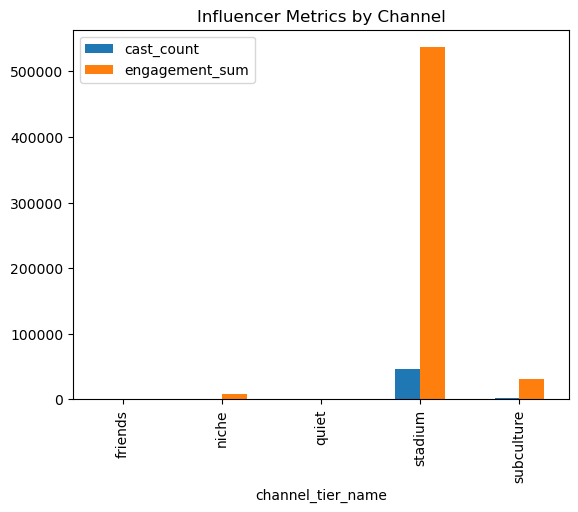

In [122]:
# influencer_metrics = get_influencer_channel_metrics('influencer_name', data)

influencer_metrics = get_influencer_channel_metrics('Satoushi', data)
if influencer_metrics.empty:
  print("No data found for influencer 'Satoushi'")
else:
  influencer_metrics.plot(x='channel_tier_name', y=['cast_count', 'engagement_sum'], kind='bar')
  plt.title('Influencer Metrics by Channel')
  plt.show()

### Influencer-Channel Relationships

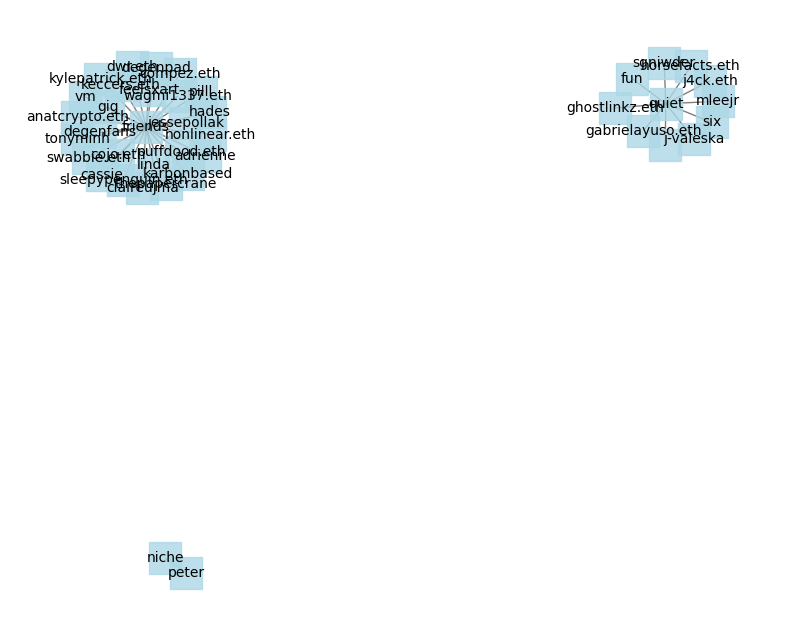

In [123]:
import networkx as nx
import matplotlib.pyplot as plt

def create_influencer_channel_graph(dominant_influencers):
  G = nx.Graph()
  for influencer, channel in dominant_influencers.items():
    G.add_node(influencer, type='influencer')
    G.add_node(channel, type='channel')
    G.add_edge(influencer, channel)
  return G

#  graph
influencer_channel_graph = create_influencer_channel_graph(dominant_influencers)

# Visualize the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(influencer_channel_graph)
nx.draw_networkx_nodes(influencer_channel_graph, pos, node_size=500, node_color='lightblue', node_shape='s', alpha=0.8)
nx.draw_networkx_edges(influencer_channel_graph, pos, width=1, alpha=0.5)
nx.draw_networkx_labels(influencer_channel_graph, pos, font_size=10, font_family='sans-serif')
plt.axis('off')
plt.show()

### Channel-Specific Influencers

In [124]:
def get_influencers_by_channel_dominance(data, dominance_threshold=0.8):
  influencers = set(data['Influencers'].str.split(',').explode())
  channel_specific_influencers = {}
  for influencer in influencers:
    channel_metrics = get_influencer_channel_metrics(influencer, data)
    channel_dominance = channel_metrics['cast_count'] / channel_metrics['cast_count'].sum()
    dominant_channel = channel_dominance.idxmax()
    if channel_dominance[dominant_channel] >= dominance_threshold:
      channel_specific_influencers[influencer] = dominant_channel
  return channel_specific_influencers


dominant_influencers = get_influencers_by_channel_dominance(data, dominance_threshold=0.7)  

#  DataFrame for better analysis
dominant_influencer_df = pd.DataFrame({'influencer': list(dominant_influencers.keys()), 'dominant_channel': list(dominant_influencers.values())})
dominant_influencer_df


,influencer,dominant_channel
0,degenpad,0
1,zaak,0
2,apex777,0
3,anatcrypto.eth,0
4,ghostlinkz.eth,0
...,...,...
127,project7,3
128,pfista,0
129,cybershakti,0
130,christin,0


### Analyzing Influencer Collaboration

In [128]:


from sklearn.feature_extraction.text import CountVectorizer

# document-term matrix for influencers
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(','))
influencer_matrix = vectorizer.fit_transform(data['Influencers'])

# co-occurrence matrix
influencer_cooccurrence = influencer_matrix.T * influencer_matrix

#  DataFrame for easier analysis

influencer_cooccurrence_df = pd.DataFrame(influencer_cooccurrence.toarray(), index=vectorizer.get_feature_names_out(), columns=vectorizer.get_feature_names_out())
#influencer_cooccurrence_df

### Identifying Influencer Clusters

In [129]:


from sklearn.cluster import KMeans

# Apply K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)  # Adjust n_clusters as needed
influencer_clusters = kmeans.fit_predict(influencer_cooccurrence_df)

# Add cluster labels to the influencer DataFrame
influencer_cooccurrence_df['cluster'] = influencer_clusters

### Domains Corresponding to a Particular Channel

In [133]:

def get_channel_specific_domains(channel, data):
    channel_data = data[data['channel_tier_name'].str.contains(channel, case=False)]
    domains_per_channel = set(channel_data['Top_Domains'].str.split(',').explode())
    return domains_per_channel

# Example usage:
channel_of_interest = "stadium"
specific_domains = get_channel_specific_domains(channel_of_interest, data.copy())

if not specific_domains:
    print(f"No domains found for channel '{channel_of_interest}'")
else:
    print(f"Domains corresponding to channel '{channel_of_interest}': {specific_domains}")

Domains corresponding to channel 'stadium': {'sonata.tips', 'app.checkincaster.xyz', 'giveth.io', 'blockmedia.co.kr', 'github.com', 'farther.social', 'lunchbreak.com', 'build.top', 't.ly', 'code.lqotp.site', 'youtube.com', 'f.hellwach.io', 'hypersub.withfabric.xyz', 'airstack.xyz', 'drakula.app', 'maps.app.goo.gl', 'i.pinimg.com', 'photos.smugmug.com', 'my-yard-frame.jam.so', 'degen-alw.pages.dev', 'degen.tips', 'superrare.com', 'rodeo.club', 'zora.co', 'frames.tasseo.xyz', 'wallet.coinbase.com', 'imagedelivery.net', 'powerfeed.vercel.app', 'app.wildcard.lol', 'app.questn.com', 'memecaster.co', 't.me', 'app.layer3.xyz', 'youtu.be', 'maps.google.com', 'foundation.app', 'open.spotify.com', 'far.quest', 'objkt.com', 'client.warpcast.com', 'moxie-frames.airstack.xyz', 'on.soundcloud.com', 'media.tenor.com'}


### Domains Associated with Specific Channels

In [134]:
def get_channel_domains(data):
   
    exploded_domains = data['Top_Domains'].str.split(',', expand=True).stack().reset_index(level=1, drop=True)
    exploded_domains.name = 'domain'

    # Combine with original DataFrame
    data_with_domains = pd.concat([data, exploded_domains], axis=1)

    # Group by channel and domain, then count occurrences
    domain_counts = data_with_domains.groupby(['channel_tier_name', 'domain']).size().reset_index(name='count')

    return domain_counts

# Example usage:
channel_domain_counts = get_channel_domains(data)
print(channel_domain_counts)

     channel_tier_name                             domain  count
0              friends                                       270
1              friends                            0xG.xyz      1
2              friends                        404media.co      1
3              friends  6365-103-76-139-15.ngrok-free.app      1
4              friends                     9to5google.com      1
...                ...                                ...    ...
1265        subculture                    theguardian.com      1
1266        subculture                wallet.coinbase.com      7
1267        subculture                           youtu.be     11
1268        subculture                        youtube.com      4
1269        subculture                            zora.co     16

[1270 rows x 3 columns]


### Domain Frequency and Identifying Top Domains

In [141]:
def calculate_domain_frequency(domain_counts):
    total_domains = domain_counts['count'].sum()
    channel_frequencies = domain_counts.groupby(['channel_tier_name', 'domain'])['count'].transform('sum') / total_domains
    domain_frequencies = domain_counts.copy()
    domain_frequencies['frequency'] = channel_frequencies
    return domain_frequencies

In [142]:
def get_top_domains(domain_frequencies, top_n=5):
    top_domains = domain_frequencies.sort_values(by=['channel_tier_name', 'frequency'], ascending=False)
    top_domains = top_domains.groupby('channel_tier_name').head(top_n)
    return top_domains

In [143]:
domain_counts = get_channel_domains(data)
domain_frequencies = calculate_domain_frequency(domain_counts)
top_domains = get_top_domains(domain_frequencies, top_n=3)

print(top_domains)

     channel_tier_name               domain  count  frequency
1201        subculture  degen-alw.pages.dev     60   0.004110
1269        subculture              zora.co     16   0.001096
1263        subculture                 t.me     13   0.000890
1151           stadium            build.top     16   0.001096
1154           stadium  degen-alw.pages.dev     13   0.000890
1187           stadium              zora.co     11   0.000753
821              quiet                        9118   0.624521
895              quiet  degen-alw.pages.dev    854   0.058493
1141             quiet             youtu.be     31   0.002123
688              niche  degen-alw.pages.dev    175   0.011986
678              niche            build.top     29   0.001986
820              niche              zora.co     29   0.001986
171            friends  degen-alw.pages.dev   1015   0.069521
0              friends                         270   0.018493
563            friends                 t.me     85   0.005822


### Visualizing Domain Distribution

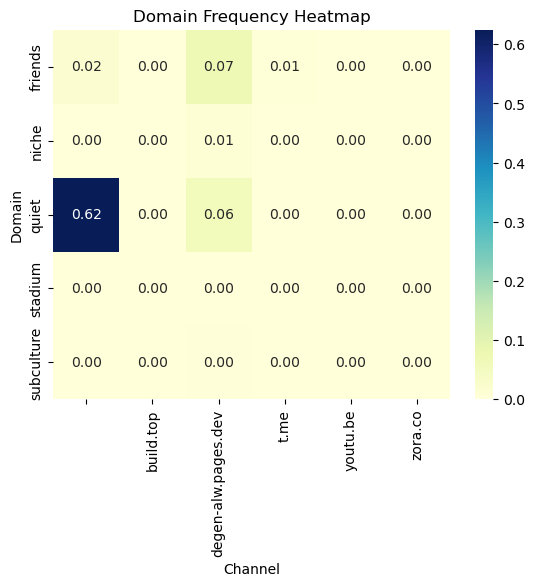

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pivot table for heatmap
domain_freq_table = top_domains.pivot_table(index='channel_tier_name', columns='domain', values='frequency').fillna(0)

# Create heatmap
sns.heatmap(domain_freq_table, cmap="YlGnBu", annot=True, fmt=".2f")  # Adjust parameters as needed
plt.title('Domain Frequency Heatmap')
plt.xlabel('Channel')
plt.ylabel('Domain')
plt.show()

### Influencers/Domains by Channel Tier

In [152]:
def get_tier_dominant_influencers(tier_name, data, dominance_threshold=0.8):
    tier_data = data[data['channel_tier'] == tier_name]
    tier_influencers = set(tier_data['Influencers'].str.split(',').explode())
    all_influencers = set(data['Influencers'].str.split(',').explode())
    
    # Calculate dominance
    influencer_counts = data['Influencers'].str.split(',').explode().value_counts()
    tier_influencer_counts = tier_data['Influencers'].str.split(',').explode().value_counts()
    dominance_scores = tier_influencer_counts / influencer_counts
    
    dominant_influencers = set(dominance_scores[dominance_scores >= dominance_threshold].index)
    return dominant_influencers

In [153]:
def create_influencer_overlap_matrix(data):
    influencers = data['Influencers'].str.split(',').explode().unique()
    channels = data['channel_tier_name'].unique()

    overlap_matrix = pd.DataFrame(index=influencers, columns=channels)
    overlap_matrix = overlap_matrix.fillna(0)

    for index, row in data.iterrows():
        for influencer in row['Influencers'].split(','):
            overlap_matrix.loc[influencer, row['channel_tier_name']] = 1

    return overlap_matrix

### <font color='Blue'> Understanding Influencer Performance Across Channels </font>

### 1. Influencer-Level Engagement Metrics: 

In [ ]:
def calculate_influencer_channel_performance(data):
  influencer_channel_data = data.groupby(['Influencers', 'channel_tier_name']).agg({
      'engagement': 'sum',
      'got_casts': 'sum',
      'casters': 'sum',
      'got_replies': 'sum',
      'got_likes': 'sum',
      'got_recasts': 'sum'
  }).reset_index()

  return influencer_channel_data

In [157]:
# Calculate engagement metrics
def calculate_total_engagement(influencer_channel_data):
  total_engagement = influencer_channel_data.groupby('Influencers')['engagement'].sum().reset_index()
  return total_engagement

def calculate_channel_engagement(influencer_channel_data):
  channel_engagement = influencer_channel_data.groupby('channel_tier_name')[['engagement', 'got_casts', 'casters', 'got_replies', 'got_likes', 'got_recasts']].sum().reset_index()
  return channel_engagement

<AxesSubplot:xlabel='Influencers'>

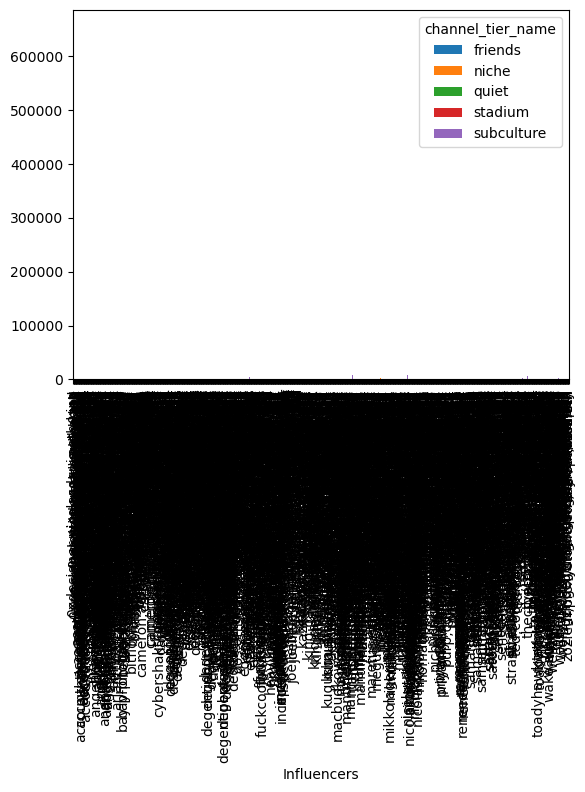

In [162]:
influencer_channel_data = calculate_influencer_channel_performance(data)
total_engagement = calculate_total_engagement(influencer_channel_data)

# Visualize engagement rate by influencer and channel
influencer_channel_data.pivot_table(index='Influencers', columns='channel_tier_name', values='engagement').plot(kind='bar')
#plt.show()

#### Target Insights through ML models:

1. Correlation between engagement metrics and user activity.
2. Impact of channel age on engagement and user growth.
3. Identifying key drivers of engagement.

In [164]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# relevant columns
data_selected = data[['engagement', 'got_casts', 'casters', 'trading_experts', 'contract_experts', 'onchain_experts', 'got_replies', 'got_likes', 'got_recasts']]

# missing values analysis(if any)
data_selected = data_selected.fillna(0)  

# Split data into features and target variable
X = data_selected.drop('engagement', axis=1)
y = data_selected['engagement']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [165]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)

# Decision Tree
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)

# Random Forest
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

In [166]:
# Evaluate models
from sklearn.metrics import mean_squared_error

print("Linear Regression MSE:", mean_squared_error(y_test, lr_predictions))
print("Decision Tree MSE:", mean_squared_error(y_test, dt_predictions))
print("Random Forest MSE:", mean_squared_error(y_test, rf_predictions))

Linear Regression MSE: 3029445.695000592
Decision Tree MSE: 40448613.005945675
Random Forest MSE: 51814627.611237496


#### Inferences: 

1. High Error Values: All three models (Linear Regression, Decision Tree, Random Forest) exhibit very high MSE values. 
2. This indicates a significant discrepancy between predicted and actual engagement values.

#### Potential Reasons:

##### 1. Limited Features: 
The model might lack sufficient information to capture the complex relationships between influencer performance and engagement metrics.

##### 2. Non-Linear Relationships: 
1. Linear regression might not be suitable for capturing potentially non-linear relationships between features and engagement. 
2. Decision Trees and Random Forest, although more flexible, might still require additional features or hyperparameter tuning for better performance.

## Predicting Optimal channel based on user activity

In [185]:


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

data_clean = data.dropna()

# Update X, y based on the cleaned data
X = data_clean[['engagement', 'got_casts', 'casters', 'trading_experts', 'contract_experts', 'onchain_experts', 'got_replies', 'got_likes', 'got_recasts']]
y = data_clean['channel_tier_name']


# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

imputer = SimpleImputer(strategy='mean')
imputer.fit(X_train)
X_train_imputed = imputer.transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 

In [182]:
# SVM

from sklearn.svm import SVC

svm_model = SVC()
svm_model.fit(X_train_imputed, y_train)
svm_predictions = svm_model.predict(X_test_imputed)

# Evaluate the model
print("SVM Accuracy:", accuracy_score(y_test, svm_predictions))

SVM Accuracy: 0.7163461538461539


In [180]:
# Neural networks

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


# Assuming categorical target variable
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test) 


model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_scaled,y_train_encoded, epochs=50, batch_size=32, validation_split=0.2)

nn_predictions = model.predict(X_test_scaled)
nn_predicted_labels = np.argmax(nn_predictions, axis=1)

Epoch 1/50


2024-08-10 02:07:46.477719: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


42/42 [==============================] - 0s 3ms/step - loss: 1.4490 - accuracy: 0.6280 - val_loss: 1.1938 - val_accuracy: 0.6997
Epoch 2/50
42/42 [==============================] - 0s 1ms/step - loss: 0.9732 - accuracy: 0.6860 - val_loss: 0.7915 - val_accuracy: 0.7237
Epoch 3/50
42/42 [==============================] - 0s 1ms/step - loss: 0.7741 - accuracy: 0.7116 - val_loss: 0.6923 - val_accuracy: 0.7387
Epoch 4/50
42/42 [==============================] - 0s 1ms/step - loss: 0.6988 - accuracy: 0.7312 - val_loss: 0.6370 - val_accuracy: 0.7628
Epoch 5/50
42/42 [==============================] - 0s 1ms/step - loss: 0.6464 - accuracy: 0.7523 - val_loss: 0.5975 - val_accuracy: 0.7688
Epoch 6/50
42/42 [==============================] - 0s 1ms/step - loss: 0.6115 - accuracy: 0.7575 - val_loss: 0.5693 - val_accuracy: 0.7718
Epoch 7/50
42/42 [==============================] - 0s 1ms/step - loss: 0.5800 - accuracy: 0.7643 - val_loss: 0.5538 - val_accuracy: 0.7748
Epoch 8/50
42/42 [=============

In [190]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report


# One-Hot Encode the target variable (y_train and y_test)
encoder = OneHotEncoder(sparse=False)
y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.values.reshape(-1,1))

print("SVM Accuracy:", accuracy_score(y_test, svm_predictions))
print("Neural Network Accuracy:", accuracy_score(y_test, nn_predicted_labels))

print("SVM Classification Report:\n", classification_report(y_test, svm_predictions))
print("Neural Network Accuracy:", accuracy_score(y_test, nn_predicted_labels))

SVM Accuracy: 0.7163461538461539
Neural Network Accuracy: 0.0
SVM Classification Report:
               precision    recall  f1-score   support

     friends       0.72      1.00      0.84       285
       niche       0.00      0.00      0.00        40
       quiet       0.00      0.00      0.00        67
     stadium       1.00      0.80      0.89         5
  subculture       0.90      0.47      0.62        19

    accuracy                           0.72       416
   macro avg       0.52      0.45      0.47       416
weighted avg       0.54      0.72      0.61       416

Neural Network Accuracy: 0.0


/Users/lalithaprasuna/opt/anaconda3/envs/DL/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lalithaprasuna/opt/anaconda3/envs/DL/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lalithaprasuna/opt/anaconda3/envs/DL/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

#### Inferences: 

1. The Neural Network currently indicates poor prediction performance.
2. The classification report shows high precision and recall for the "friends" class but very low values for other classes like "niche" and "quiet." 
3. This suggests potential class imbalance in the data, where some classes have significantly fewer data points compared to others.